<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">PROJET 9 DATA ANALYST</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Produisez une étude de marché avec R ou Python</h2>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Partie 1 - Préparation, nettoyage et analyse exploratoire des données</h2>
</div>

# Table des matières
* [Etape 1 - Importation des librairies, chargement des fichiers et définition de fonctions](#etape1)
    * [1.1 - Importation des librairies](#section1_1)
    * [1.2 - Graphiques](#section1_2)
    * [1.3 - Chargement des fichiers](#section1_3)
    * [1.4 - Définition de fonctions](#section1_4)
* [Etape 2 - Analyse et nettoyage des fichiers](#etape2)
    * [2.1 - Analyse et nettoyage du dataset](#section2_1)
        * [2.1.1. Analyse](#section2_1_1)
        * [2.1.2. Sélecton des données et nettoyage](#section2_1_2)
        * [2.1.3. Ecriture du fichier](#section2_1_2)
* [Etape 3 - Split du dataset](#etape3)
* [Etape 4 - Analyse exploratoire par PCA](#etape4)
    * [4.1 - Scaling](#section4_1)
    * [4.2 - PCA](#section4_2)
    * [4.3 - Variance expliquée et scree plot](#section4_3)
    * [4.4 - Composantes](#section4_4)
    * [4.5 - Graphe de corrélation](#section4_5)
    * [4.6 - Projections](#section4_6)

<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape1"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies, chargement des fichiers et définition de fonctions</h2></a>
</div>

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section1_1"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.1 - Importation des librairies</h3></a>
</div>

Importation des des librairies python nécéssaires à l'analyse préparatoire.

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section1_2"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.2 - Graphiques</h3></a>
</div>

On charge seaborn :

In [2]:
sns.set()

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section1_3"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.3 - Chargement des données</h3></a>
</div>

In [3]:
#Chargement et visualisation du fichier
dataset = pd.read_csv("dataset.csv", sep=";")

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section1_4"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.4 - Définition de fonctions</h3></a>
</div>

Création de la fonction permettant d'afficher le graphe de corrélation.

In [4]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

Affiche la projection des individus.

In [5]:
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker=".", 
                                noms_points = True):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if noms_points :
        if len(labels) :
            # j'ai copié collé la fonction sans la lire
            for i,(_x,_y) in enumerate(X_[:,[x,y]]):
                plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()



<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape2"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse et nettoyage des fichiers</h2></a>
</div>

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section2_1"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">2.1 - Analyse et nettoyage du dataset</h3></a>
</div>

<a class="anchor" id="section2_1_1"><h3 style="color: RGB(0,150,250); ">2.1.1. Analyse</h3></a>

In [6]:
#visualisation des premières lignes
dataset.head()

,Pays,Indice_performance_logistique_2016,Population,IDH,Revenu_national_brut,production_co2,Importations - Quantité,Production,Disponibilité intérieure,Nourriture,Disponibilité alimentaire en quantité (kg/personne/an),Taux_de_change,Index_Maximum_Conectivité_maritime,Political_Stability,PIB_par_habitant
0,Afghanistan,"1,835473",36296113,"0,482","2085,487571","0,188995444",29,28,57,55,"1,53","68,02690408",0,"-2,8","530,1498626"
1,Angola,"2,133789",29816766,"0,597","6861,575738","0,953168429",277,42,319,315,"10,56","165,9159507","26,325","-0,33","2283,214233"
2,Albanie,"1,980952",2884169,"0,802","12802,14831","1,838241795",38,13,47,47,"16,36","119,1","4,845","0,38","4531,032207"
3,Émirats Arabes Unis,"4,069324",9487203,"0,897","67667,50846","17,79568752",433,48,412,412,"43,47","3,6725","71,0975","0,62","43063,96748"
4,Argentine,"2,856412",43937140,"0,851","22996,67142","4,274395193",8,2161,1962,1856,"42,24","16,56270693","32,7975","0,17","14613,03571"


In [7]:
#visualisation des dernières lignes
dataset.tail()

,Pays,Indice_performance_logistique_2016,Population,IDH,Revenu_national_brut,production_co2,Importations - Quantité,Production,Disponibilité intérieure,Nourriture,Disponibilité alimentaire en quantité (kg/personne/an),Taux_de_change,Index_Maximum_Conectivité_maritime,Political_Stability,PIB_par_habitant
133,Venezuela,"2,345295",29402484,"0,744","12321,887","5,49394058",25,600,626,596,"20,28","9,975","11,935","-1,25",12400
134,Viet Nam,"2,695191",94600648,"0,692","6611,941253","2,063931951",291,918,1206,1166,"12,33","22370,08667","58,41","0,29","2992,071746"
135,Afrique du Sud,"3,776261",57009756,"0,72","13475,98821","8,142443199",514,1667,2118,2035,"35,69","13,32380142","39,715","-0,28","6734,475153"
136,Zambie,"2,262771",16853599,"0,568","3330,552717","0,386694854",12,49,60,58,"3,42","9,5175",0,"0,15","1495,752138"
137,Zimbabwe,"2,213516",14236595,"0,594","3728,918785","0,673026099",6,69,76,67,"4,68",322,0,"-0,71","1192,107012"


In [8]:
#dimensions du dataframe
dataset.shape
print('Le dataframe compte ',dataset.shape[0],' individus pour',dataset.shape[1],'variables.')

Le dataframe compte  138  individus pour 15 variables.


In [9]:
#Indications sur les variables
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 15 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   Pays                                                    138 non-null    object
 1   Indice_performance_logistique_2016                      138 non-null    object
 2   Population                                              138 non-null    int64 
 3   IDH                                                     138 non-null    object
 4   Revenu_national_brut                                    138 non-null    object
 5   production_co2                                          138 non-null    object
 6   Importations - Quantité                                 138 non-null    int64 
 7   Production                                              138 non-null    int64 
 8   Disponibilité intérieure                          

In [10]:
#Calcul de la proportion de valeurs manquantes dans le dataset
dataset.isna().mean()

Pays                                                      0.0
Indice_performance_logistique_2016                        0.0
Population                                                0.0
IDH                                                       0.0
Revenu_national_brut                                      0.0
production_co2                                            0.0
Importations - Quantité                                   0.0
Production                                                0.0
Disponibilité intérieure                                  0.0
Nourriture                                                0.0
Disponibilité alimentaire en quantité (kg/personne/an)    0.0
Taux_de_change                                            0.0
Index_Maximum_Conectivité_maritime                        0.0
Political_Stability                                       0.0
PIB_par_habitant                                          0.0
dtype: float64

In [11]:
#Y a-t-il des valeurs en double ?
print('Il y a',dataset.duplicated().sum(),'valeurs en double')

Il y a 0 valeurs en double


In [12]:
#Combien y a-t-il de valeurs différentes par colonne ?
dataset.nunique()

Pays                                                      138
Indice_performance_logistique_2016                        138
Population                                                138
IDH                                                       121
Revenu_national_brut                                      138
production_co2                                            138
Importations - Quantité                                    79
Production                                                116
Disponibilité intérieure                                  121
Nourriture                                                116
Disponibilité alimentaire en quantité (kg/personne/an)    136
Taux_de_change                                            104
Index_Maximum_Conectivité_maritime                        112
Political_Stability                                       113
PIB_par_habitant                                          138
dtype: int64

In [13]:
#dispersion globale des données
dataset.describe()

,Population,Importations - Quantité,Production,Disponibilité intérieure,Nourriture
count,1.380000e+02,138.000000,138.000000,138.000000,138.000000
mean,5.140852e+07,100.282609,856.768116,822.471014,785.601449
std,1.698011e+08,198.714812,2741.344495,2407.034385,2352.177645
min,2.070890e+05,0.000000,0.000000,2.000000,2.000000
25%,4.674954e+06,3.000000,23.250000,47.000000,47.000000
50%,1.107878e+07,22.000000,91.500000,133.500000,132.000000
75%,3.734761e+07,98.500000,583.250000,611.000000,523.000000
max,1.421022e+09,1069.000000,21914.000000,18266.000000,18100.000000


<a class="anchor" id="section2_1_2"><h3 style="color: RGB(0,150,250); ">2.1.2. Sélection des données et nettoyage</h3></a>

La sélection des données a été faite sur tableau prep.

In [14]:
#Gestion des erreus de types pour les données, cela est du au caractère délimitant les parties entières et les décimales.

#création d'une liste qui contient les attributs avec un problème de type
liste=['Indice_performance_logistique_2016', 'IDH','Revenu_national_brut', 'production_co2','Disponibilité alimentaire en quantité (kg/personne/an)','Taux_de_change', 'Index_Maximum_Conectivité_maritime','Political_Stability', 'PIB_par_habitant']


for i in liste:
    #transformation des "," en "."
    dataset[i]=dataset[i].str.replace(',', '.', regex=True)
    #Conversion des colonnes
    dataset[i]=dataset[i].astype(float)

Suppression d'attributs

In [15]:
dataset=dataset.drop(columns=['Revenu_national_brut'])

In [16]:
#Passage des noms de pays en index
data=dataset.set_index('Pays')
data.head()

,Indice_performance_logistique_2016,Population,IDH,production_co2,Importations - Quantité,Production,Disponibilité intérieure,Nourriture,Disponibilité alimentaire en quantité (kg/personne/an),Taux_de_change,Index_Maximum_Conectivité_maritime,Political_Stability,PIB_par_habitant
Pays,,,,,,,,,,,,,
Afghanistan,1.835473,36296113,0.482,0.188995,29,28,57,55,1.53,68.026904,0.0000,-2.80,530.149863
Angola,2.133789,29816766,0.597,0.953168,277,42,319,315,10.56,165.915951,26.3250,-0.33,2283.214233
Albanie,1.980952,2884169,0.802,1.838242,38,13,47,47,16.36,119.100000,4.8450,0.38,4531.032207
Émirats Arabes Unis,4.069324,9487203,0.897,17.795688,433,48,412,412,43.47,3.672500,71.0975,0.62,43063.967480
Argentine,2.856412,43937140,0.851,4.274395,8,2161,1962,1856,42.24,16.562707,32.7975,0.17,14613.035710


<a class="anchor" id="section2_1_3"><h3 style="color: RGB(0,150,250); ">2.1.3. Ecriture du fichier</h3></a>
<p>Ecriture du dataset dans un fichier CSV qui servira pour le clustering</p>

In [17]:
data.to_csv('dataset_nettoye.csv')

<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape3"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Split du dataset</h2></a>
</div>

Nous allons ensuite séparer nos données. Premièrement `X` la matrice des données :

In [18]:
#Isolation des valeurs
X = data.values
#Visualisation des 5 premières lignes
X[:5]

array([[ 1.83547300e+00,  3.62961130e+07,  4.82000000e-01,
         1.88995444e-01,  2.90000000e+01,  2.80000000e+01,
         5.70000000e+01,  5.50000000e+01,  1.53000000e+00,
         6.80269041e+01,  0.00000000e+00, -2.80000000e+00,
         5.30149863e+02],
       [ 2.13378900e+00,  2.98167660e+07,  5.97000000e-01,
         9.53168429e-01,  2.77000000e+02,  4.20000000e+01,
         3.19000000e+02,  3.15000000e+02,  1.05600000e+01,
         1.65915951e+02,  2.63250000e+01, -3.30000000e-01,
         2.28321423e+03],
       [ 1.98095200e+00,  2.88416900e+06,  8.02000000e-01,
         1.83824180e+00,  3.80000000e+01,  1.30000000e+01,
         4.70000000e+01,  4.70000000e+01,  1.63600000e+01,
         1.19100000e+02,  4.84500000e+00,  3.80000000e-01,
         4.53103221e+03],
       [ 4.06932400e+00,  9.48720300e+06,  8.97000000e-01,
         1.77956875e+01,  4.33000000e+02,  4.80000000e+01,
         4.12000000e+02,  4.12000000e+02,  4.34700000e+01,
         3.67250000e+00,  7.10975000e

In [19]:
#Vérification du type de X
type(X)

numpy.ndarray

La forme de cette matrice est conforme à nos attentes :

In [20]:
X.shape

(138, 13)

Deuxièmement nous enregistrons les noms des pays dans une variable `names` :

In [21]:
names = data.index
names

Index(['Afghanistan', 'Angola', 'Albanie', 'Émirats Arabes Unis', 'Argentine',
       'Arménie', 'Australie', 'Autriche', 'Belgique', 'Bénin',
       ...
       'République-Unie de Tanzanie', 'Ouganda', 'Ukraine', 'Uruguay',
       'États-Unis', 'Venezuela', 'Viet Nam', 'Afrique du Sud', 'Zambie',
       'Zimbabwe'],
      dtype='object', name='Pays', length=138)

Troisièmement nos colonnes, nos features, dans une variable `features` :

In [22]:
features = data.columns
features

Index(['Indice_performance_logistique_2016', 'Population', 'IDH',
       'production_co2', 'Importations - Quantité', 'Production',
       'Disponibilité intérieure', 'Nourriture',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Taux_de_change', 'Index_Maximum_Conectivité_maritime',
       'Political_Stability', 'PIB_par_habitant'],
      dtype='object')

<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape4"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Analyse exploratoire par PCA</h2></a>
</div>

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section4_1"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4.1 - Scaling</h3></a>
</div>

Commençons par scaler les données. On instancie :

In [23]:
scaler = StandardScaler()

On fit et transforme :

In [24]:
X_scaled = scaler.fit_transform(X)

Vérifions si nous avons bien une moyenne à 0 et un écart type à 1 :

In [25]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8,9,10,11,12
mean,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section4_2"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4.2 - PCA</h3></a>
</div>

Nous allons travailler que sur les 13 composantes :

In [26]:
n_components = 13

On instancie notre ACP :

In [27]:
pca = PCA(n_components=n_components)

On l'entraine sur les données scalées :

In [28]:
pca.fit(X_scaled)

PCA(n_components=13)

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section4_3"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4.3 - Variance expliquée et scree plot</h3></a>
</div>

Intéressons nous maintenant à la variance *captée* par chaque nouvelle composante.

In [29]:
explained_variance=pca.explained_variance_ratio_
print(explained_variance)
print('Ici la 1ère composante capte',round(explained_variance[0]*100,2),'% des données initiales, la deuxième',round(explained_variance[1]*100,2),'%,ect ...')

[3.91069856e-01 2.43326327e-01 8.01254375e-02 7.56051310e-02
 6.28861476e-02 3.85856638e-02 3.35677059e-02 3.08882099e-02
 1.82741973e-02 1.48522135e-02 1.01876980e-02 5.60597671e-04
 7.08150086e-05]
Ici la 1ère composante capte 39.11 % des données initiales, la deuxième 24.33 %,ect ...


Enregistrons cela dans une variable (on arrondis les pourcentages à deux chiffres après la virgule):

In [30]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([3.911e+01, 2.433e+01, 8.010e+00, 7.560e+00, 6.290e+00, 3.860e+00,
       3.360e+00, 3.090e+00, 1.830e+00, 1.490e+00, 1.020e+00, 6.000e-02,
       1.000e-02])

Calculons la *somme cumulée* :

In [31]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 39.,  63.,  71.,  79.,  85.,  89.,  93.,  96.,  97.,  99., 100.,
       100., 100.])

Définisons ensuite une variable avec la liste de nos composantes :

In [32]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Affichage de l'éboulis des valeurs propres et des pourcentages cumulés d'inertie.

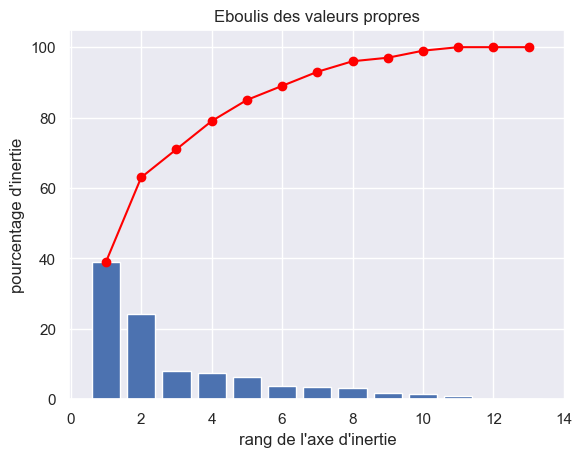

In [33]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On a en bleu le pourcentage d'inertie de chaque composante, et en rouge la variance cumulée.

On voit ici que près de 80% de la variance est comprise dans les 4 premières composantes.

Le coude de la courbe de la somme cumulé des inerties se situe pour un rang de 8.

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section4_4"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4.4 - Composantes</h3></a>
</div>

Calcul des composantes.

In [34]:
pcs = pca.components_

Affichage en version `pandas` :

In [35]:
pcs = pd.DataFrame(pcs)

Renommage des noms de composantes et des features

In [36]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs

,Indice_performance_logistique_2016,Population,IDH,production_co2,Importations - Quantité,Production,Disponibilité intérieure,Nourriture,Disponibilité alimentaire en quantité (kg/personne/an),Taux_de_change,Index_Maximum_Conectivité_maritime,Political_Stability,PIB_par_habitant
F1,0.347881,0.190246,0.318992,0.287596,0.228922,0.309122,0.318175,0.317879,0.281540,-0.022919,0.330597,0.196586,0.283449
F2,-0.198702,0.373441,-0.311387,-0.229992,-0.026843,0.360300,0.369890,0.366042,-0.183835,0.087563,0.105774,-0.342422,-0.316157
F3,-0.104606,0.001100,0.046655,0.070907,-0.659342,0.235487,0.161720,0.168393,0.088634,-0.429955,-0.425199,0.214423,0.132916
F4,-0.099417,-0.086363,0.080159,0.173512,-0.337824,0.076319,0.051693,0.055848,0.143662,0.878001,-0.137014,0.100435,0.001114
F5,0.364701,0.362367,0.004202,-0.276838,-0.151544,-0.056908,-0.040617,-0.054167,-0.641319,0.151985,0.000203,0.317631,0.304892
F6,0.149051,0.319344,-0.058258,0.630061,-0.160985,-0.133078,-0.100912,-0.108868,-0.150075,-0.029640,-0.081238,-0.586884,0.187981
F7,-0.003080,0.455319,0.229648,-0.148060,-0.426280,-0.195699,-0.177420,-0.206692,0.326953,-0.057982,0.457698,0.049232,-0.318797
F8,-0.337976,0.435626,-0.017755,0.404397,0.319184,-0.105866,-0.011417,-0.024005,-0.093626,-0.021390,-0.264860,0.491898,-0.311480
F9,-0.066251,0.404290,0.224035,-0.411855,0.243336,-0.078104,-0.026151,-0.034018,0.375356,0.084275,-0.498428,-0.232021,0.308109
F10,0.018484,0.134312,-0.809665,0.012647,-0.026303,-0.073917,-0.052615,-0.051932,0.368368,0.025318,0.132056,0.209926,0.341227


Plus visuellement, cela donne :

<Axes: >

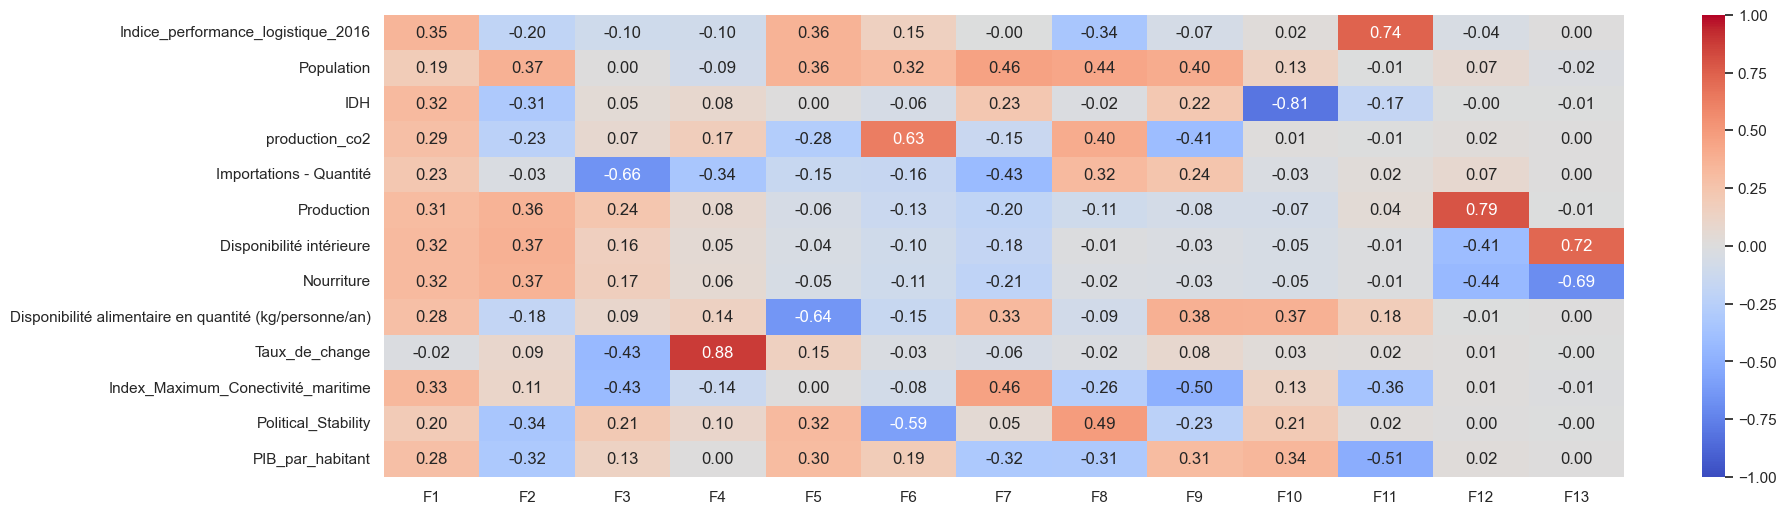

In [37]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section4_5"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4.5 - Graphe de corrélation</h3></a>
</div>

<a class="anchor" id="section4_5_1"><h3 style="color: RGB(0,150,250); ">4.5.1 Graphe de corrélation de F1 et F2</h3></a>

Définissons nos axes x et y. Nous allons utiliser les 2 premières composantes.

In [38]:
x, y = 0,1

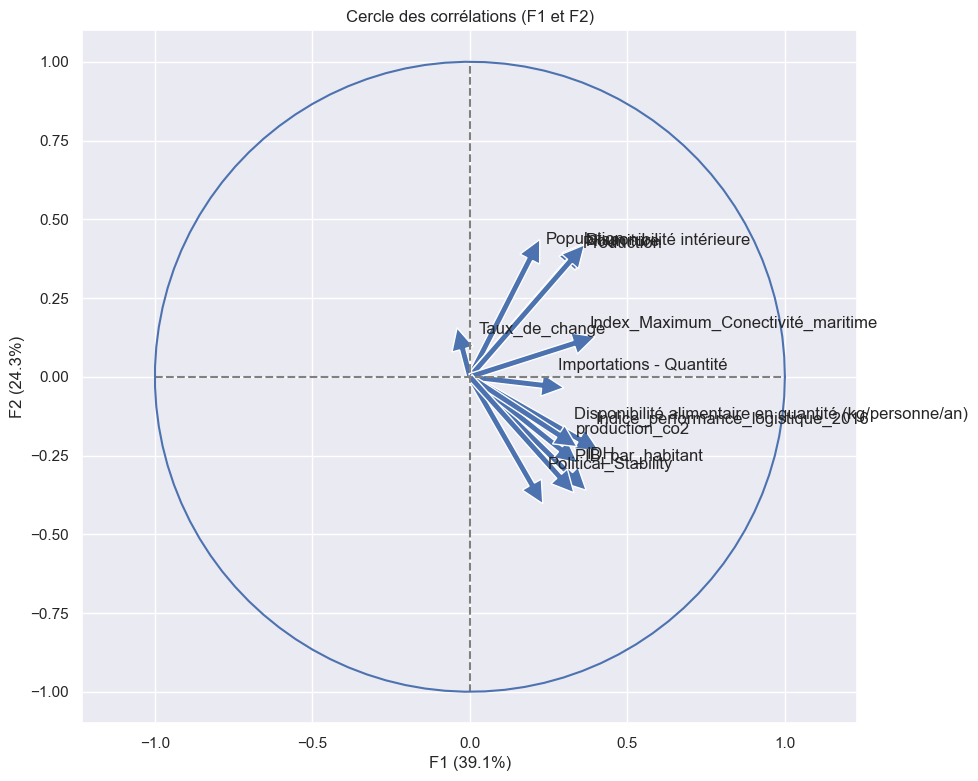

In [39]:
#définition du couple (x;y) nécéssaire pour la fonction
x_y=x, y
#Mise en oeuvre de la fonction
correlation_graph(pca,x_y,features)

Analyse :

F1 : Capacité de port d'un pays (+connectivité, +CO2, +performance logistique)

F2 : Capacité d'un pays à produire du poulet (+Production +Disponibilité +Nourriture, -stabilité)

<a class="anchor" id="section4_5_2"><h3 style="color: RGB(0,150,250); ">4.5.2 Graphe de corrélation de F3 et F4</h3></a>

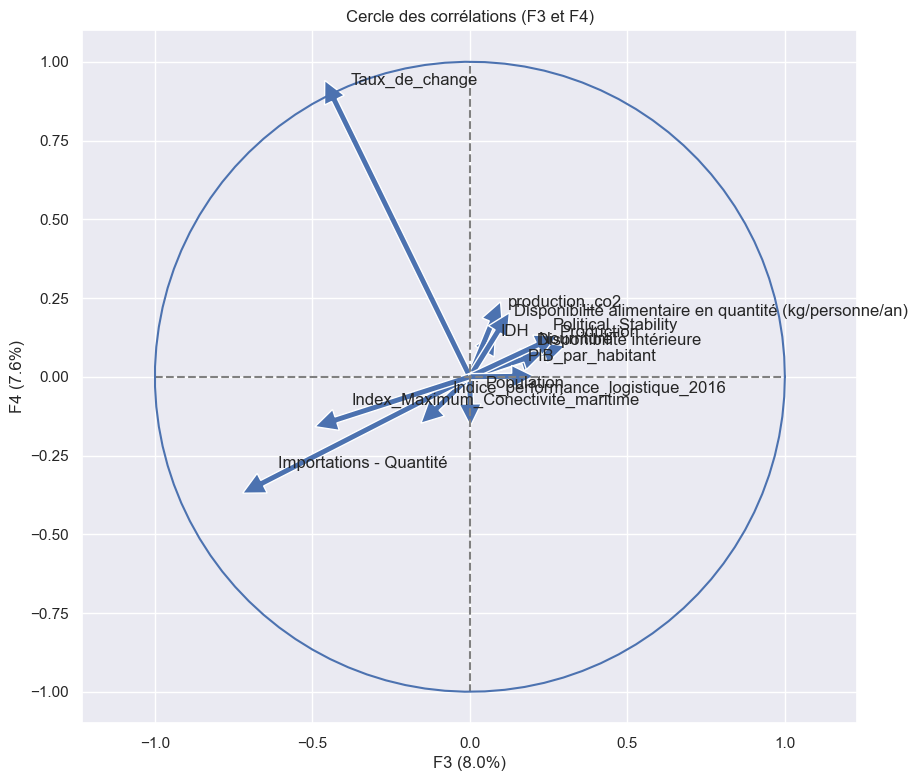

In [40]:
correlation_graph(pca, (2,3), features)

Analyse :

F3 : Incapacité à se réaprovisionner (-Connectivité maritime -Importation)

F4 : Force de la monaie (++Taux de change)

<a class="anchor" id="section4_5_3"><h3 style="color: RGB(0,150,250); ">4.5.3 Graphe de corrélation de F5 et F6</h3></a>

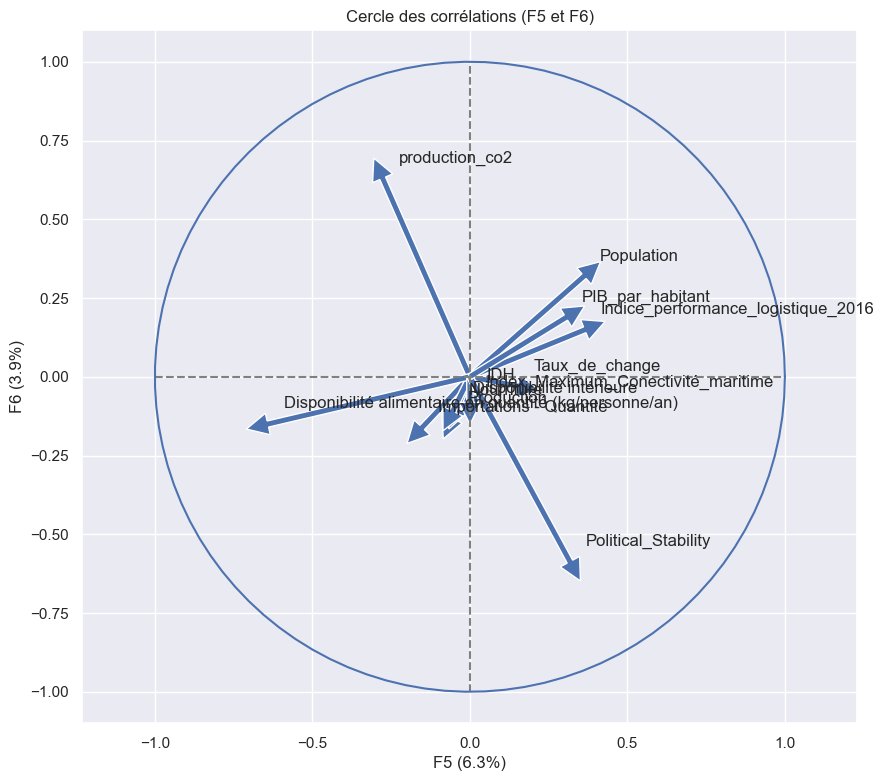

In [41]:
correlation_graph(pca, (4,5), features)

Analyse :

F5 :  (-dispo alimentaire par personne, +performance logistique, + PIB par hab, ~+Population)

F6 : Industrialisation du pays (+CO2, -stabilité)

<a class="anchor" id="section4_5_4"><h3 style="color: RGB(0,150,250); ">4.5.4 Graphe de corrélation de F7 et F8</h3></a>

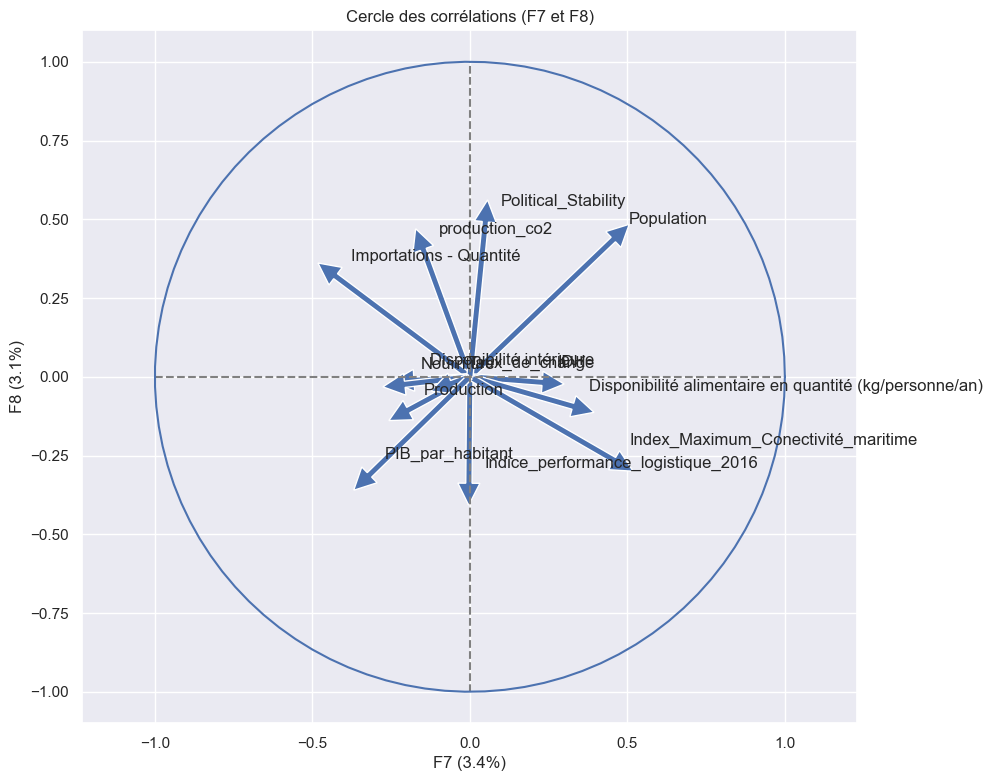

In [42]:
correlation_graph(pca, (6,7), features)

Analyse :

F7 :  (+populatiuon, +connectivité maritime, -importations)

F8 :  (-logistique, +stabilité, +CO2)

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section4_6"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4.6 - Projections</h3></a>
</div>

Travaillons maintenant sur la projection des dimensions.

In [43]:
#Calcul des coordonnées des individus dans le nouvel espace :
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-3.09085902e+00,  1.97483334e+00, -2.77629582e-01,
        -6.05683354e-01, -6.39734721e-01,  1.40595849e+00,
        -7.00046283e-01, -8.55178449e-01,  4.90692939e-01,
        -1.35840861e-01, -3.14163184e-01,  2.12387285e-02,
         2.76482228e-03],
       [-1.21487220e+00,  6.56320199e-01, -8.36245833e-01,
        -7.11167075e-01, -2.16756657e-01, -5.26551049e-01,
        -3.67370004e-01,  4.54872846e-01, -4.20076118e-02,
         2.05398880e-01, -3.35086303e-01,  1.49338078e-02,
        -6.76014178e-03],
       [-1.16364531e+00, -3.48041484e-01,  5.99184973e-01,
         9.93840554e-02, -1.75927946e-01, -8.02797993e-01,
         1.60619130e-01,  6.72468231e-01,  2.59070107e-01,
        -6.07099019e-01, -4.32875489e-01,  8.68088517e-03,
        -8.28124913e-03],
       [ 3.56539000e+00, -2.59754534e+00, -1.30587011e+00,
        -3.26646547e-01, -8.06524458e-01,  1.01571946e+00,
         1.03552801e-01,  2.63583105e-01, -6.62475973e-01,
         6.82321680e-01,  1.48893683e

Projetons les individus sur F1 et F2 :

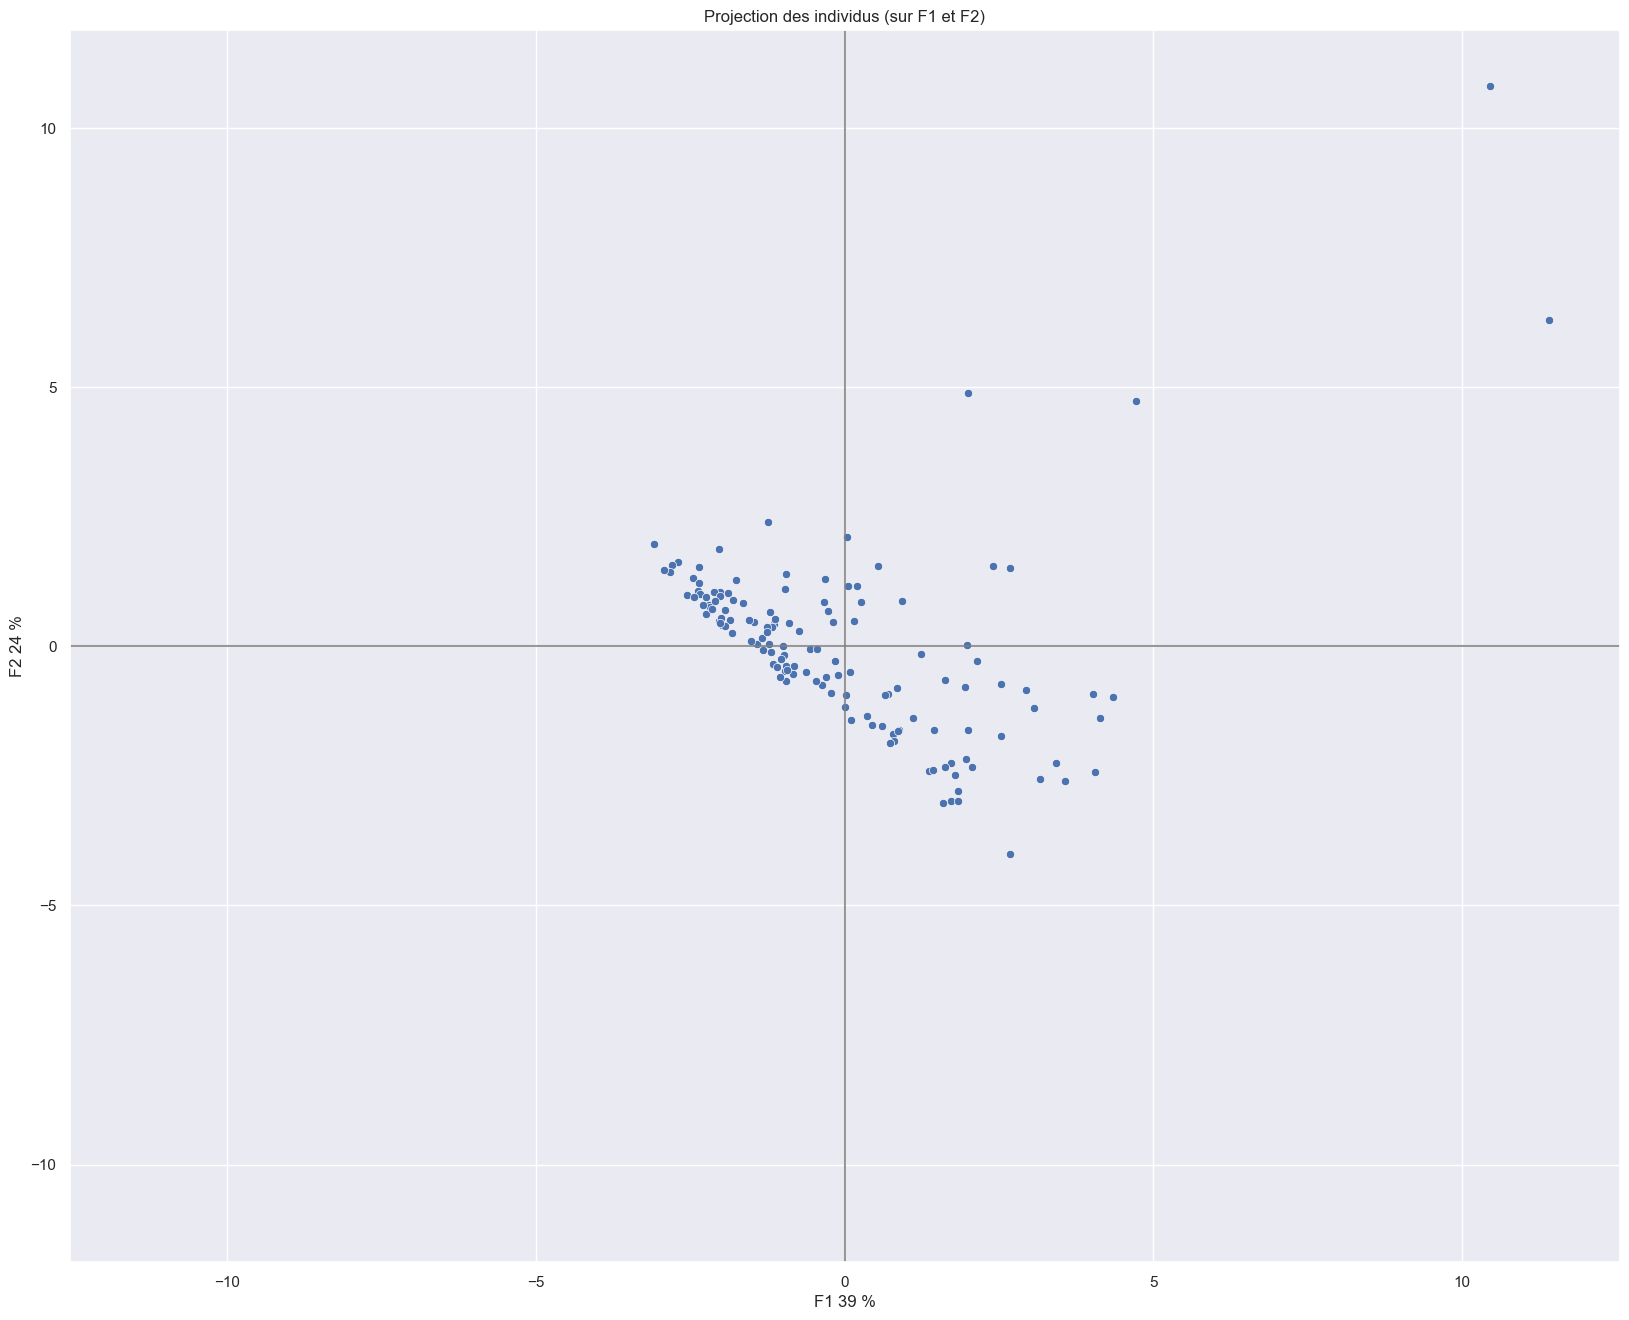

In [44]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16), marker="o",noms_points=False)

Projeté sur F2 et F3 :

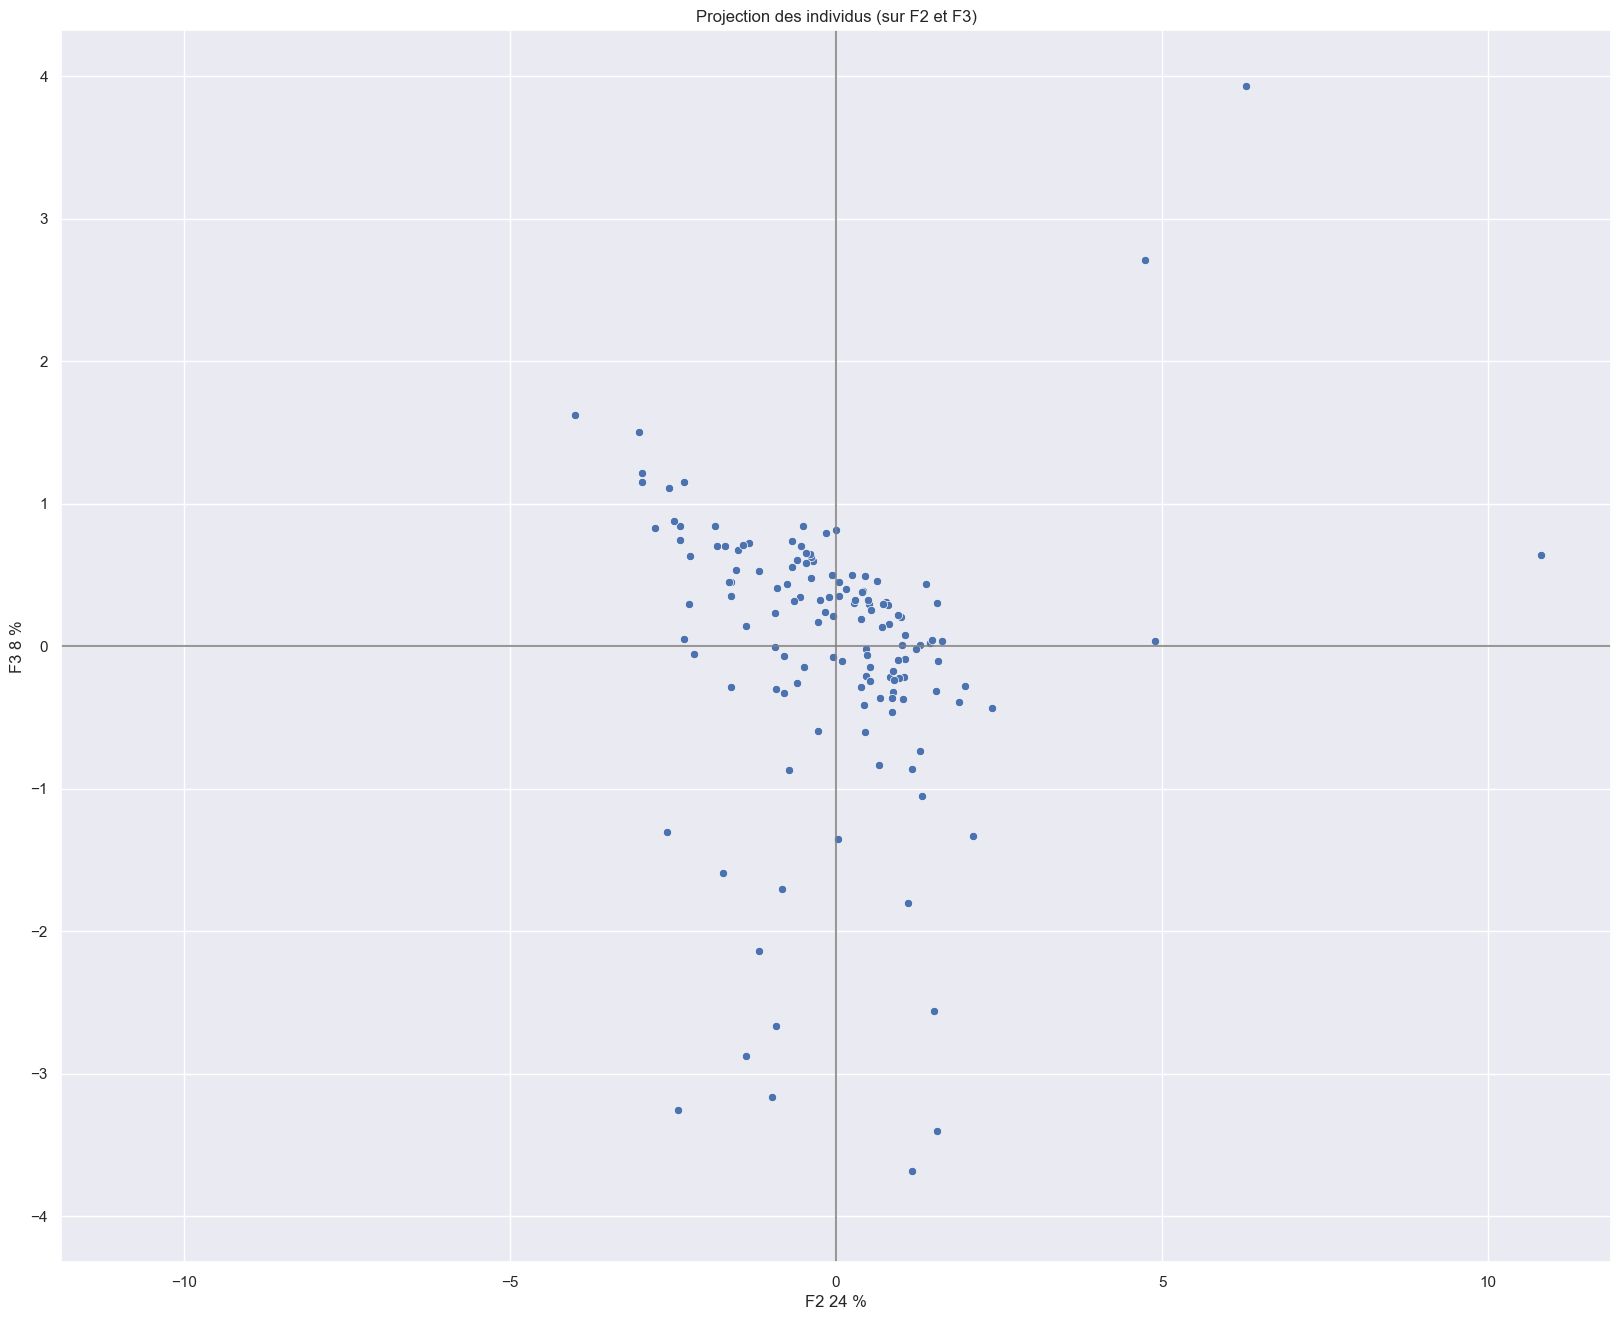

In [45]:
x_y = 1,2
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16),marker="o",noms_points=False)

Projections sur F3 et F4

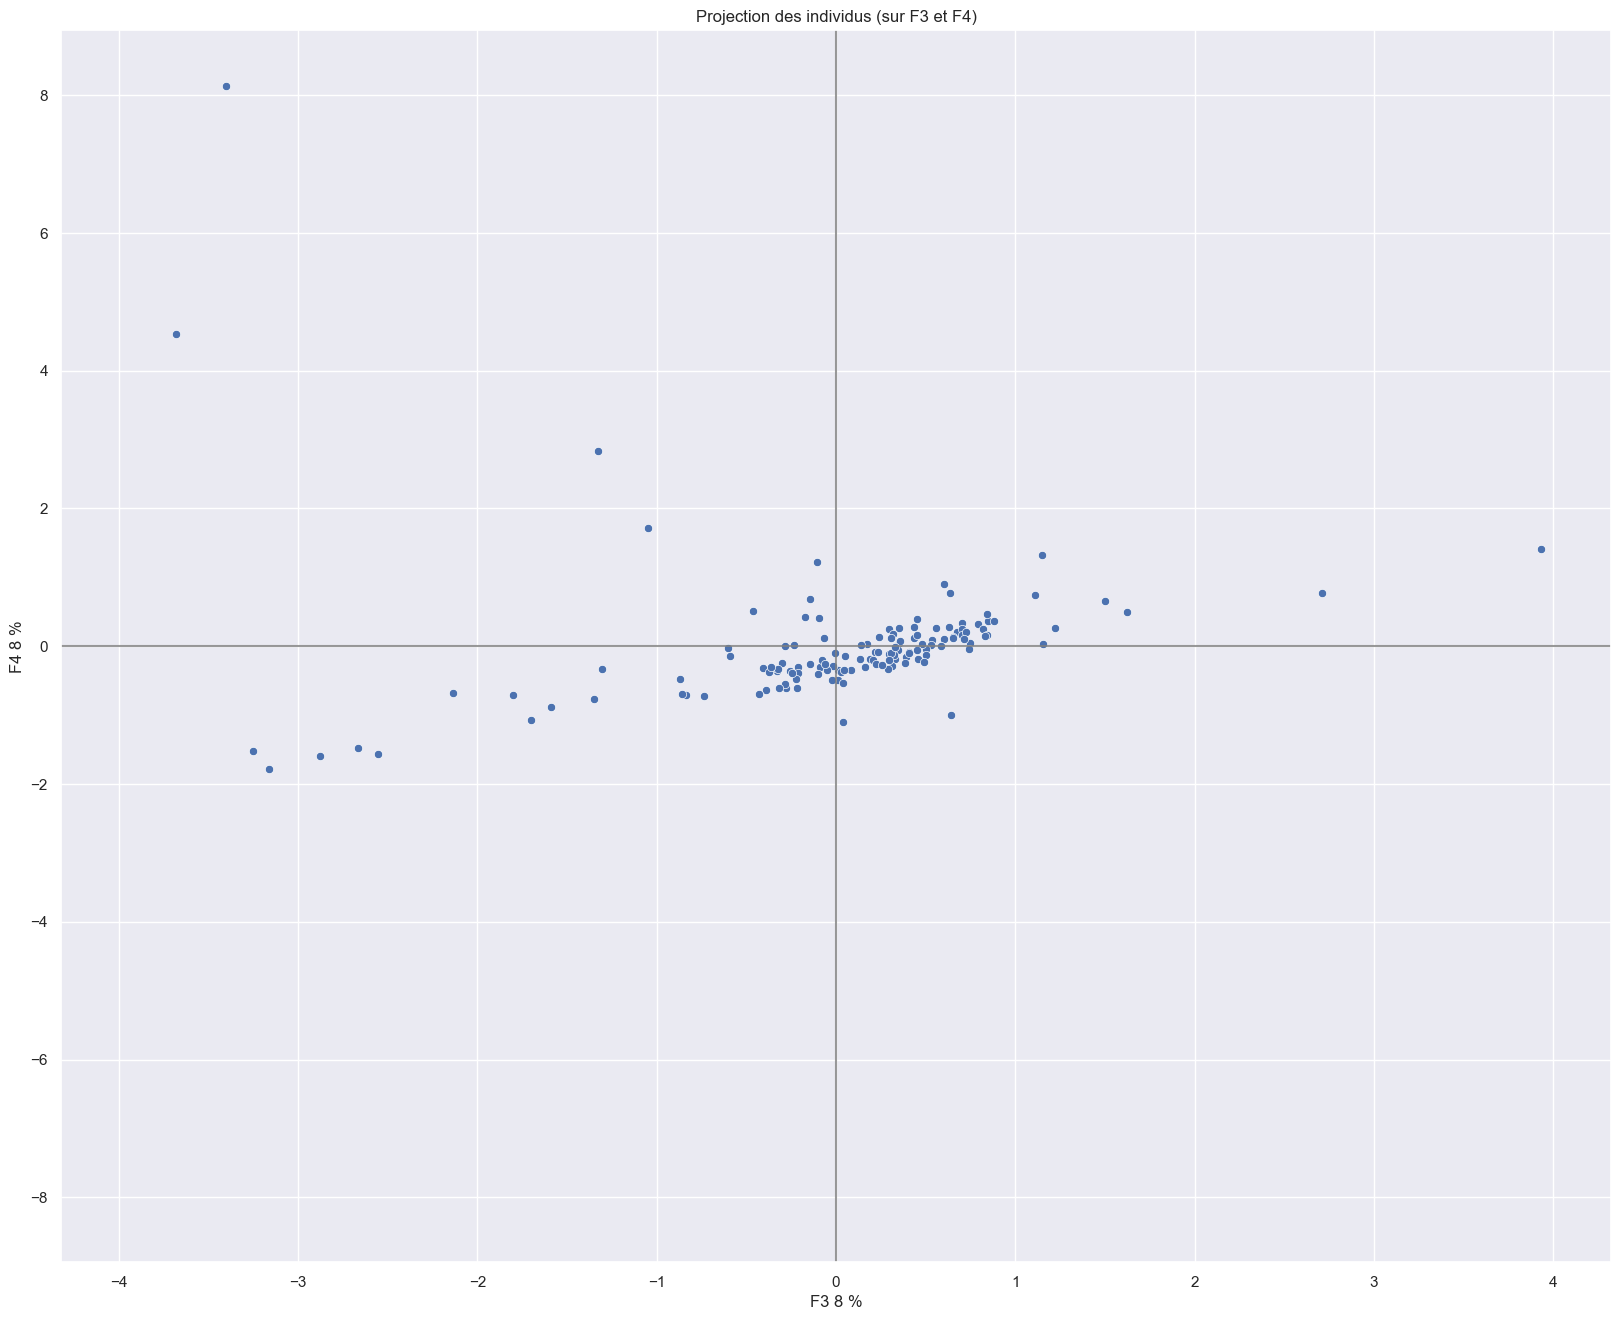

In [46]:
x_y = 2,3
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16),marker="o",noms_points=False)

Projections sur F1 et F3

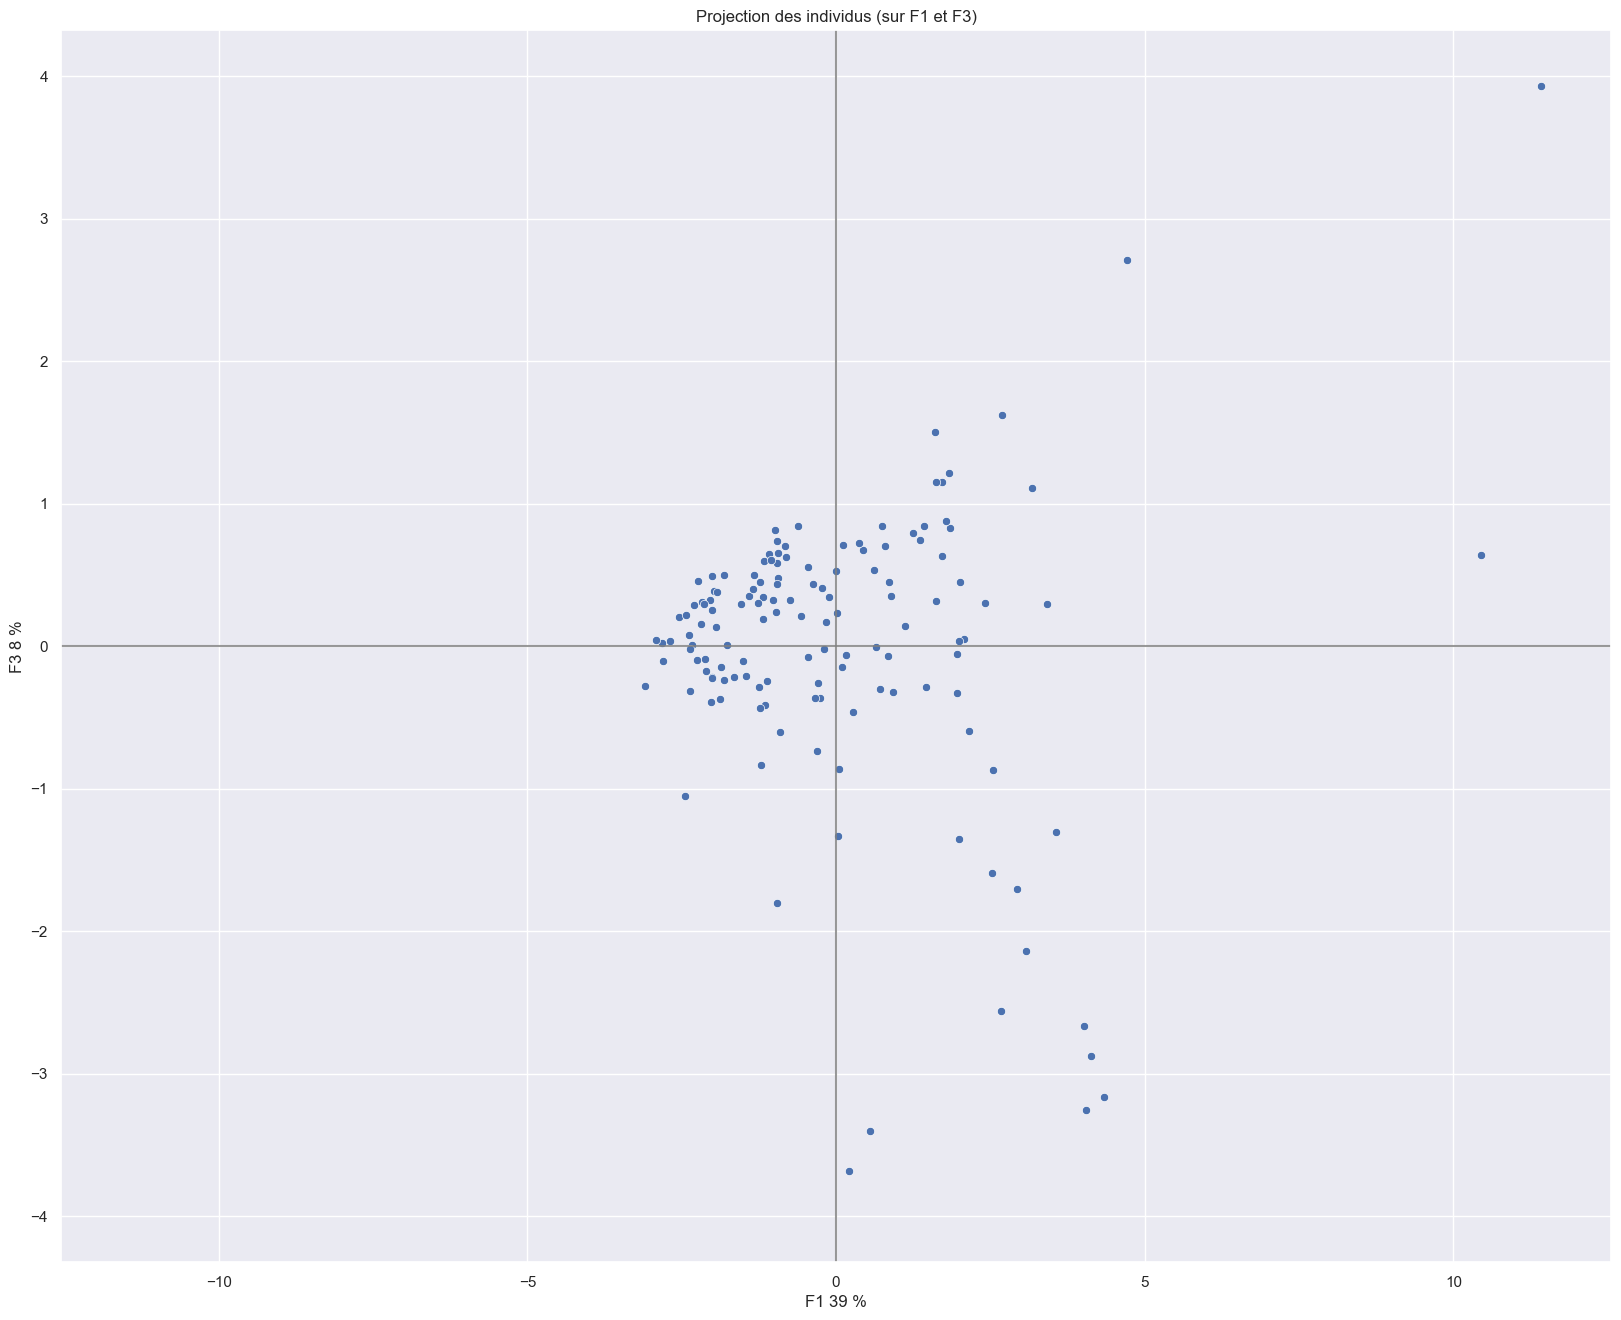

In [47]:
x_y = 0,2
display_factorial_planes(X_proj, x_y, pca, labels=names, figsize=(20,16),marker="o",noms_points=False)

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section4_7"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4.7 - Sortie</h3></a>
</div>

Création d'un dataframe de sortie avec les 8 premières dimensions synthétiques.

In [48]:
df_synthese = pd.DataFrame(X_proj)
df_synthese.columns = [f"F{i}" for i in x_list]
df_synthese.index = names
df_synthese=df_synthese.drop(columns=['F9','F10','F11','F12','F13'])
df_synthese

,F1,F2,F3,F4,F5,F6,F7,F8
Pays,,,,,,,,
Afghanistan,-3.090859,1.974833,-0.277630,-0.605683,-0.639735,1.405958,-0.700046,-0.855178
Angola,-1.214872,0.656320,-0.836246,-0.711167,-0.216757,-0.526551,-0.367370,0.454873
Albanie,-1.163645,-0.348041,0.599185,0.099384,-0.175928,-0.802798,0.160619,0.672468
Émirats Arabes Unis,3.565390,-2.597545,-1.305870,-0.326647,-0.806524,1.015719,0.103553,0.263583
Argentine,1.239784,-0.158445,0.792568,0.324074,-0.943654,-0.611947,0.789682,-0.347362
...,...,...,...,...,...,...,...,...
Venezuela,-0.739630,0.293449,0.327066,-0.014733,-0.806396,0.847683,-0.073165,-0.319306
Viet Nam,0.205425,1.159937,-3.681089,4.526335,1.169605,-1.014359,-0.041190,0.270497
Afrique du Sud,1.989604,0.024150,-1.351955,-0.772698,-1.023264,0.024584,-0.498794,0.243681


In [49]:
df_synthese.to_csv('dataset_synthese.csv')